# Seminar 21
# Penalty method and augmented Lagrangian method

## Reminder

- Interrior point method
- Barrier method with logarithmic barrier
- Primal-dual method

## Penalty method

**Idea:** barriers prevent iterands to move outside of the feasible set, and penalty functions leads to significantly increasing of the objective function in the case of lying iterands outside of the feasible set. However, this scenario is possible.

## Equality constrained problem

\begin{equation*}
\begin{split}
& \min f(x)\\
\text{s.t. } & g_i(x) = 0, \; i=1,\ldots,m
\end{split}
\end{equation*}

### Quadratic penalty method
Original problem can be reformulated as unconstrained optimization problem 

$$
\min_x Q(x, \mu),
$$

where 

$$
Q(x, \mu) = f(x) + \frac{\mu}{2}\sum\limits_{i=1}^mg^2_i(x), \quad \mu > 0
$$

- If constraints is not satisfied, then objective function increases proportionally to $\mu$
- While the value of $\mu$ increases, solution of the unconstrained problem is satisfied constraints more and more accurately

### General scheme

```python
def QudraticPenaltyEquality(Q, gradQ, x0, get_mu, get_tau, **kwargs):
    while True:
        # Stop when norm of gradient of Q is less than current tau
        x = MinimizeQ(Q, gradQ, x0, get_tau)
        if global_cnvergence(x, Q, **kwargs):
            break
        mu = get_mu()
        Q, gradQ = UpdateQ(mu)
        x0 = UpdateStartPoint(x, Q)
    return x
```

- Parameter $\mu$ has to be changed depending on the complexity opf solveing subproblem: if it is known that subproblem is solved long time, then $\mu$ has to be changed more smoothly, for example $\mu_{k+1} = 2\mu_k$. 
If subproblem is solved fast, then more aggresive changing of $\mu$ is acceptable, e.g. $\mu_{k+1} = 15\mu_k$.
- While increasing $\mu$, solving of the subproblem is more and more difficult due to poor conditioning of the hessian. More details below.

### Convergence

**Theorem 1.** Assume that for every $\mu$ unconstrained optimization problem has finite global solution. Then the sequence of the subproblems solutions converges to global solution of the original problem while $\mu \to \infty$

- Issue: global optimum for some subproblems can be unreachable!

**Theorem 2.** Assume $\tau_k \to 0$ and $\mu_k \to \infty$ and $\| Q'(x^*_k, \mu_k) \| \leq \tau_k$. Then 
- if $x^*_k \to x^*$ and $x^*$ is infeasible, then $x^*$ is stationary point of the function $\| g(x) \|^2_2$;
- if $x^*$ is feasible and gradients of the constraints in this point are linearly independent, then $x^*$ is the point in which KKT conditions are satisfied.

For any subsequence $x^*_k \to x^*, \; k \in \mathcal{C}$ the following holds

$$
\lim_{k \in \mathcal{C}} \mu_k g_i(x_k) = \lambda_i^*
$$

for all $i = 1,\ldots,m$, where $\lambda_i^*$ is Lagrange multipliers that satisfied KKT.

### Singularity of hessian 

**Example.**
\begin{equation*}
\begin{split}
& \min -5x_1^2 + x_2^2\\
\text{s.t. }& x_1 = 1
\end{split}
\end{equation*}
Penalty function
$$
Q(x, \mu) = -5x_1^2 + x_2^2 + \frac{\mu}{2}(x_1 - 1)^2
$$
**Note** While $\mu < 10$ function $Q(x, \mu)$ is unbounded below for $x$ and subproblem does not have finite solution 

### General form of hessian

$$
Q''(x, \mu) = f''(x) + \mu\sum_{i=1}^m g_i(x) g''_i(x) + \mu(g'(x))^{\top} g'(x),
$$

where $g'(x)$ is Jacobian of the vector-function representing equality constraints.

From theorem 2, the following approximation holds near the optimum point

$$
Q''(x, \mu) \approx L''(x, \lambda^*) + \mu(g'(x))^{\top} g'(x)
$$

- hessian of Lagrangian does not depend on $\mu$
- product $(g'(x))^{\top} g'(x)$ has rank of $m \ll n$

**Summary:** some of the eigenvalues of hessian $Q''(x, \mu)$ are of the order $\mu$, therefore increasing $\mu$ leads to singularity of hessian

**Corollary:** search direction in the Newton method is very inaccurate!

### How to find direction in Mewton method?

$$
Q''(x_k, \mu)p = -Q'(x_k, \mu)
$$

Let us introduce new variable $\xi = \mu g'(x) p$ and re-write the system in the form

$$ \begin{bmatrix} f''(x) + \mu \sum\limits_{i=1}^m g_i(x)g_i''(x) & g'(x)\\ (g'(x))^{\top} & -\frac{1}{\mu} I \end{bmatrix} = \begin{bmatrix} -Q'(x, \mu) \\ 0 \end{bmatrix} $$

- Condition numbner of this system is no longer increased while increasing $\mu$
- Dimension is increased by $m$
- Quadratic approximation can still be inadequate

## Equality and inequality constraimed problem 

\begin{equation*}
\begin{split}
& \min_x f(x)\\
\text{s.t. } & g_i(x) = 0, \; i=1,\ldots,m \\
& h_j(x) \leq 0, \; j = 1,\ldots,p
\end{split}
\end{equation*}

### Penalty function

$$
\min_x f(x) + \frac{\mu}{2}\sum\limits_{i=1}^mg^2_i(x) + \frac{\mu}{2}\sum\limits_{j=1}^p (\max(0, h_j(x)))^2,
$$
where $\mu > 0$
- Difference from the equality constrained problem: second derivative of penalty function is discontinuous and consequently penalty function is no longer twice continuously differentiable

### Experiment

Consider the problem
\begin{equation*}
\begin{split}
& \min \|x\|_2 \\
\text{s.t. } & Ax = b
\end{split}
\end{equation*}
 
and solve it with the penalty functions

In [1]:
import cvxpy
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.rc("text", usetex=True)

num_iters = 10
n = 20
m = 10
A = np.random.randn(m, n)
b = np.random.randn(m, 1)

# Initialize problem
x = cvxpy.Variable(shape=(n, 1))
f = cvxpy.norm(x, 2)

# Solve with CVXPY.
cvxpy.Problem(cvxpy.Minimize(f), [A*x == b]).solve()
cvxpy_f = f.value
print ("Optimal value from CVXPY =", f.value)

Optimal value from CVXPY = 0.8556575455477898


In [2]:
# Solve with method of augmented Lagrangian
resid = A*x - b
mu = cvxpy.Parameter(value=1, nonneg=True)
penal_f = f + (mu/2.)*cvxpy.sum_squares(resid)
res_conv = []
f_conv = []
for t in range(num_iters):
    cvxpy.Problem(cvxpy.Minimize(penal_f)).solve()
    mu.value = mu.value * 2
    res_conv.append(np.linalg.norm(resid.value))
    f_conv.append(f.value)

print("Optimal value from method of augmented Lagrangian =", f.value)

Optimal value from method of augmented Lagrangian = 0.8549282692100597


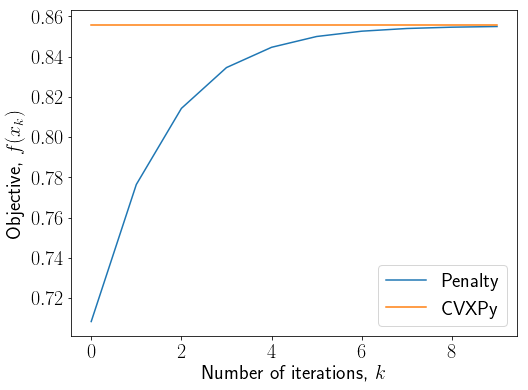

In [3]:
plt.figure(figsize=(8, 6))
fontsize=20
plt.plot(f_conv, label="Penalty")
plt.plot(np.ones(num_iters) * cvxpy_f, label="CVXPy")
plt.legend(fontsize=fontsize)
plt.xlabel("Number of iterations, $k$", fontsize=fontsize)
plt.ylabel("Objective, $f(x_k)$", fontsize=fontsize)
plt.xticks(fontsize=fontsize)
_ = plt.yticks(fontsize=fontsize)

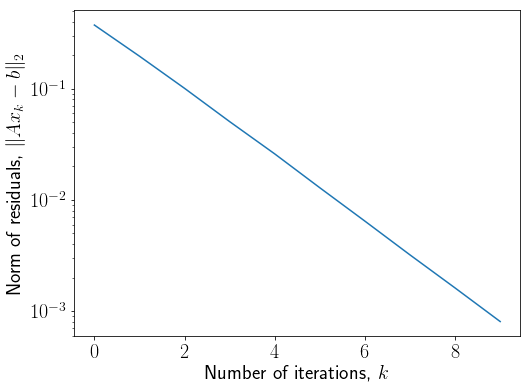

In [4]:
plt.figure(figsize=(8, 6))
fontsize=20
plt.semilogy(res_conv)
plt.xlabel("Number of iterations, $k$", fontsize=fontsize)
plt.ylabel("Norm of residuals, $\|Ax_k - b\|_2$", fontsize=fontsize)
plt.xticks(fontsize=fontsize)
_ = plt.yticks(fontsize=fontsize)

## Pro & Contra

Pro

- automatic way to convert any *constrained* optimizatiomn problem to *unconstrained* one
- you don't need to find initial guess
- somitemes small violation of constraints are acceptable
- general scheme is simple to implement

Contra

- solution of the unconstrained optimization problen is not always solutiuon of the constrained original problem
- if objective function of the original problem is defined only on the original feasible set, then penalty method is inapplicable
- quadratic approximation $Q(x, \mu)$ may be inadequate

## Augmented Lagrangian method
**Motivation:** in the penalty method solutions of the subproblems can violate constraints and it is known only that

$$
g_i(x^*_k) \approx \frac{\lambda^*}{\mu_k} \to 0, \quad \mu_k \to \infty
$$

Is it possible to fix $Q(x, \mu)$ in a way to prevent constraints violation?

**Idea:** add penalty not to the objective function, but to the Lagrangian. It is analogue of the primal-dual method, because one iteration performs updating both primal and dual variables.

## Equality constrained optimization problem

\begin{equation*}
\begin{split}
& \min f(x)\\
\text{s.t. } & g_i(x) = 0, \; i=1,\ldots,m
\end{split}
\end{equation*}

### Augmented Lagrangian
$$
M(x, \lambda, \mu) = f(x) + \sum\limits_{i=1}^m\lambda_i g_i(x) + \frac{\mu}{2}\sum\limits_{i=1}^mg^2_i(x)
$$

Necessary optimality condition for $M(x_k, \lambda^k, \mu_k)$
$$
f'(x_k) + \sum\limits_{i=1}^m (\lambda^k_i + \mu_k g_i(x_k) ) g'_i(x_k) \approx 0
$$
From this follows expression for $\lambda^{k+1}$
$$
\lambda^{k+1}_i = \lambda^k_i + \mu_k g_i(x_k)
$$

### Constraints violation

$$
g_i(x_k) \approx \frac{\lambda^*_i - \lambda^k_i}{\mu_k} \to 0
$$

- In the penalty method convergence of equality constraints to zero was of the order of $1/\mu_k$
- In the augmented Lagrangian method convergence to zero is faster, because not only denominator increases, but nominator also converges to zero

## Equality and inequality constraints problem
\begin{equation*}
\begin{split}
& \min_x f(x)\\
\text{s.t. } & g_i(x) = 0, \; i=1,\ldots,m \\
& h_j(x) \leq 0, \; j = 1,\ldots,p
\end{split}
\end{equation*}

### Augmented Lagrangian 

$$
M(x, \mu, \lambda, \nu) = f(x) + \sum\limits_{i=1}^m \left[\lambda_ig_i(x) + \frac{\mu}{2}g^2_i(x)\right] + \frac{1}{2\mu}\sum\limits_{j=1}^p\left[ (\nu_j + \mu h_j(x))_+^2 - \nu^2_j \right],
$$
where $\lambda$ are vector of dual variables corresponding to **equality** constraints, $\nu$ are vector of dual variables corresponding to **inequality** constraints
- See the derivation of $M(x, \mu, \lambda, \nu)$ in lecture notes.

### Updating of dual variables corresponding to inequalities constraints
$$
\nu^{k+1}_j = (\nu^k_j + \mu_k h_j(x_k))_+
$$

### Convergence

- Convergence is local (initial guess is near optimum in primal and dual variables)
- For some sufficiently large $\mu$, solutions of the subproblems will converge to the solution of the original problem, therefore one should not increase $\mu$ infinitely
- Solving subploblems is easy than in the penalty method because $\mu$ is bounded above

## Practical remarks

- Augmented Lagrangian method is preferable because solving of subproblems is as difficult as in the penalty method, but its convergence is faster
- Penalty method is preferable as regularization of the sequential quadratic programing approach ([SQP](https://en.wikipedia.org/wiki/Sequential_quadratic_programming))
- Packages [LACELOT](http://www.numerical.rl.ac.uk/lancelot/blurb.html) and [MINOS](https://en.wikipedia.org/wiki/MINOS_(optimization_software)) use different implementations of the augmented Lagrangian method
- The [paper](https://www.dropbox.com/s/rdqcn0fppumreto/MinosvsLancelot.pdf?dl=0) presents comparison of these packages, but they were developed in early 1990s using Fortran

### Experiment

Consider the following problem
\begin{equation*}
\begin{split}
& \min \|x\|_2 \\
\text{s.t. } & Ax = b
\end{split}
\end{equation*}
 
and solve it with augmented Lagrangian method.

In [1]:
import cvxpy
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.rc("text", usetex=True)

num_iters = 10
mu = 1.0
n = 20
m = 10
A = np.random.randn(m, n)
b = np.random.randn(m, 1)

# Initialize problem
x = cvxpy.Variable(shape=(n, 1))
f = cvxpy.norm(x, 2)

# Solve with CVXPY.
cvxpy.Problem(cvxpy.Minimize(f), [A*x == b]).solve()
print ("Optimal value from CVXPY =", f.value)

Optimal value from CVXPY = 1.00533447260422


In [2]:
# Solve with method of augmented Lagrangian
resid = A*x - b
y = cvxpy.Parameter(shape=(m, 1)) 
y.value = np.zeros((m, 1))
aug_lagr = f + y.T*resid + (mu/2.)*cvxpy.sum_squares(resid)
for t in range(num_iters):
    cvxpy.Problem(cvxpy.Minimize(aug_lagr)).solve()
    y.value += mu*resid.value

print("Optimal value from method of augmented Lagrangian =", f.value)

Optimal value from method of augmented Lagrangian = 1.0054190329059278


#### Dependence on the parameter $\mu$

In [3]:
mus = [0.1, 1, 10, 100]
conv_res = {}
conv_obj = {}
for mu in mus:
    conv_res[mu] = np.zeros(num_iters)
    conv_obj[mu] = np.zeros(num_iters)
    x = cvxpy.Variable(shape=(n, 1))
    f = cvxpy.norm(x, 2)
    resid = A*x - b
    y = cvxpy.Parameter(shape=(m, 1)) 
    y.value = np.zeros((m, 1))
    aug_lagr = f + y.T*resid + (mu/2.)*cvxpy.sum_squares(resid)
    for t in range(num_iters):
        cvxpy.Problem(cvxpy.Minimize(aug_lagr)).solve()
        y.value += mu*resid.value
        conv_res[mu][t] = np.linalg.norm(resid.value)
        conv_obj[mu][t] = aug_lagr.value

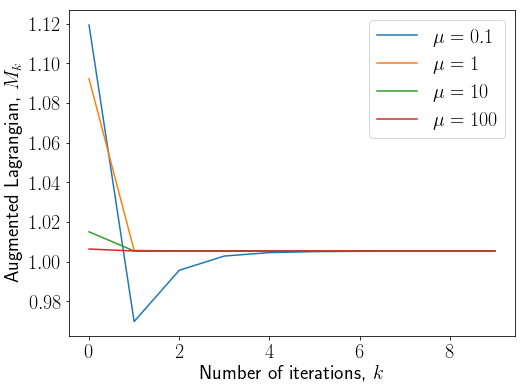

In [4]:
plt.figure(figsize=(8, 6))
fontsize=20
for mu in mus:
    plt.plot(conv_obj[mu], label=r"$\mu = {}$".format(mu))
plt.legend(fontsize=fontsize)
plt.xlabel("Number of iterations, $k$", fontsize=fontsize)
plt.ylabel("Augmented Lagrangian, $M_k$", fontsize=fontsize)
plt.xticks(fontsize=fontsize)
_ = plt.yticks(fontsize=fontsize)

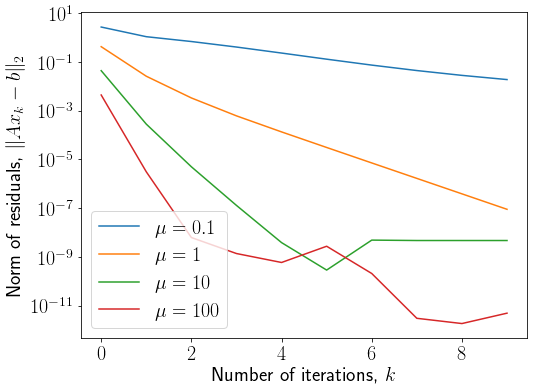

In [5]:
plt.figure(figsize=(8, 6))
fontsize=20
for mu in mus:
    plt.semilogy(conv_res[mu], label=r"$\mu = {}$".format(mu))
plt.legend(fontsize=fontsize)
plt.xlabel("Number of iterations, $k$", fontsize=fontsize)
plt.ylabel("Norm of residuals, $\|Ax_k - b\|_2$", fontsize=fontsize)
plt.xticks(fontsize=fontsize)
_ = plt.yticks(fontsize=fontsize)

## Recap

- Penalty method
- Augmented Lagrangian method